In [11]:
import numpy as np 
import sys
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import matplotlib as mpl
from scipy import signal #for filtering
import pandas as pd
import datetime as datetime
import re 
print("Modules imported")


Modules imported


In [12]:
# Information you need to input to run this script
#start date of each run (because built in time format is seconds since run started)
#for this round, they are all the same!
start1=pd.to_datetime("2020-08-11")
start2=pd.to_datetime("2020-08-11")
start3=pd.to_datetime("2020-08-11")
# File path to the station list
# for this there is only one list
stalist="/expanse/lustre/scratch/jisrael/temp_project/run_schism/run_15/station.in_2025_10_21_reformat.prn"
# File paths to the station data files
# These outputs are invoked with iout_sta=1, and are found in outputs/staout_[1..,9], corresponding respectively to elev, air pressure, wind u, wind v, T, S, u, v, w. Each output has a simple ASCII format:
# Time(sec), variable @ station 1,2,…. (specified in station.in)
file15="/expanse/lustre/scratch/jisrael/temp_project/run_schism/processed_data_for_JT/run_15_salinity_raw.csv"# 1:elev,2:air pressure,3:wind_x,4:wind_y,5:temp,6:salt,7:u,8:v,9:w
file16="/expanse/lustre/scratch/jisrael/temp_project/run_schism/processed_data_for_JT/run_16_salinity_raw.csv"
file17="/expanse/lustre/scratch/jisrael/temp_project/run_schism/processed_data_for_JT/run_17_salinity_raw.csv"

file15_filt="/expanse/lustre/scratch/jisrael/temp_project/run_schism/processed_data_for_JT/run_15_salinity_filt.csv"
file16_filt="/expanse/lustre/scratch/jisrael/temp_project/run_schism/processed_data_for_JT/run_16_salinity_filt.csv"
file17_filt="/expanse/lustre/scratch/jisrael/temp_project/run_schism/processed_data_for_JT/run_17_salinity_filt.csv"


In [13]:
# with open(stalist) as f:
#     f.readline()
#     for station in range(int(f.readline())):
#         line = f.readline()
#         if '!' in line:
#             print(line.split('!')[-1])

In [14]:
station_id =[]
with open(stalist) as f:
    f.readline()
    for station in range(int(f.readline())):
        line = f.readline()
        if '!' in line:
            station_id.append(line.split('!')[-1])
        else:
            station_id.append(None)
# print(station_id)

print(len(station_id))

stations = []
for sublist in station_id:
    match = re.search(r'"(.*?)"', sublist)
    if match:
        stations.append(match.group(1).strip())
    else :
        stations.append(sublist.replace("\n", "").strip())
print(len(set(stations)))


for i, station in enumerate(stations):
    print("%d == %s" % (i,station))

405
372
0 == San Joaquin at Antioch
1 == Mokelumne River at Benson'sFerry
2 == Cache Slough
3 == Cache Creek at Yolo
4 == Old River at ConeyIsland
5 == Clifton Court
6 == Discovery Bay at IndianSlough
7 == Doughty Cut above GrantLine Canal
8 == Sacramento River at Emmaton
9 == Sacramento River at Emmaton
10 == Emmaton
11 == Emmaton
12 == Farrar Park
13 == Grant Line Canal atTracy Rd Bridge
14 == Green's Landing
15 == Harvey O Banks PP
16 == Holland Tract
17 == Harvey O Banks PP
18 == CCWD Old River nearDiscovery Bay
19 == CCWD Rock Slough PP
20 == Italian Slough Headwater nearByron
21 == Jersey Point
22 == Sacramento River at MallardIsland
23 == Sacramento River at MallardIsland
24 == Middle River at HowardRd Bridge
25 == San Joaquin at MossdaleBridge
26 == Middle River at TracyBlvd
27 == Old River Barrier nearDMC (Above)
28 == Old River below Dam
29 == Old River at BaconIsland
30 == Old River at Head
31 == Old River at Byron
32 == Prisoners Point
33 == Rock Slough at ContraCosta Canal

In [15]:
# Print the number of locations where data was saved
len(stations)

405

In [16]:
columns = ['time']
stations_no = [str(i) for i in range(len(stations))]
columns = columns + stations_no

s15 = pd.read_csv(file15, sep='\s+', names=columns,dtype=np.float32) #, decode_times=False)
s16 = pd.read_csv(file16, sep='\s+', names=columns,dtype=np.float32) #, decode_times=False)
s17 = pd.read_csv(file17, sep='\s+', names=columns,dtype=np.float32)

#s13.time
# # Add in the number of seconds elapsed @ our chosen timestep
timedelta15 = [pd.Timedelta(i, unit = 's') for i in s15.time]
timestamp15 = [start1 + i for i in timedelta15]

timedelta16 = [pd.Timedelta(i, unit = 's') for i in s16.time]
timestamp16 = [start2 + i for i in timedelta16]

timedelta17 = [pd.Timedelta(i, unit = 's') for i in s17.time]
timestamp17 = [start3 + i for i in timedelta17]

s15["time"] = timestamp15
s16["time"] = timestamp16
s17["time"] = timestamp17


In [17]:
s15

,time,0,1,2,3,4,5,6,7,8,...,395,396,397,398,399,400,401,402,403,404
0,2020-08-11 00:15:00,2.930210,0.073461,0.079015,-9999.0,0.160813,0.162558,0.171787,0.322990,0.731469,...,0.161632,-999.0,-999.0,2.34885,-999.0,0.075525,0.606833,0.160341,0.162518,0.204669
1,2020-08-11 00:30:00,2.930300,0.073461,0.079052,-9999.0,0.160818,0.162561,0.171761,0.323550,0.731775,...,0.161636,-999.0,-999.0,2.34973,-999.0,0.075527,0.607253,0.160347,0.162527,0.204648
2,2020-08-11 00:45:00,2.930420,0.073463,0.079128,-9999.0,0.160821,0.162563,0.171720,0.324008,0.731875,...,0.161634,-999.0,-999.0,2.35045,-999.0,0.075528,0.607611,0.160352,0.162531,0.204633
3,2020-08-11 01:00:00,2.930620,0.073466,0.079195,-9999.0,0.160822,0.162564,0.171693,0.324992,0.731862,...,0.161634,-999.0,-999.0,2.35138,-999.0,0.075530,0.607684,0.160356,0.162536,0.204629
4,2020-08-11 01:15:00,2.931010,0.073467,0.079205,-9999.0,0.160823,0.162564,0.171659,0.325640,0.731868,...,0.161635,-999.0,-999.0,2.35286,-999.0,0.075531,0.607662,0.160361,0.162545,0.204637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48855,2022-01-01 22:00:00,0.259419,0.066500,0.201553,-9999.0,0.454946,0.424608,0.455338,0.271877,0.115695,...,0.577386,-999.0,-999.0,-999.00000,-999.0,0.117792,0.635017,0.724832,0.424055,0.308286
48856,2022-01-01 22:15:00,0.258092,0.066506,0.199927,-9999.0,0.455480,0.424628,0.455340,0.268911,0.124059,...,0.579053,-999.0,-999.0,-999.00000,-999.0,0.117796,0.635248,0.724800,0.426539,0.309181
48857,2022-01-01 22:30:00,0.258156,0.066531,0.198508,-9999.0,0.455958,0.424650,0.455217,0.265393,0.131211,...,0.580718,-999.0,-999.0,-999.00000,-999.0,0.117801,0.635296,0.724768,0.428673,0.310069
48858,2022-01-01 22:45:00,0.257953,0.066546,0.197266,-9999.0,0.456367,0.424673,0.454980,0.261602,0.136905,...,0.582343,-999.0,-999.0,-999.00000,-999.0,0.117806,0.635310,0.724736,0.430468,0.310929


Axes(0.125,0.11;0.775x0.77)


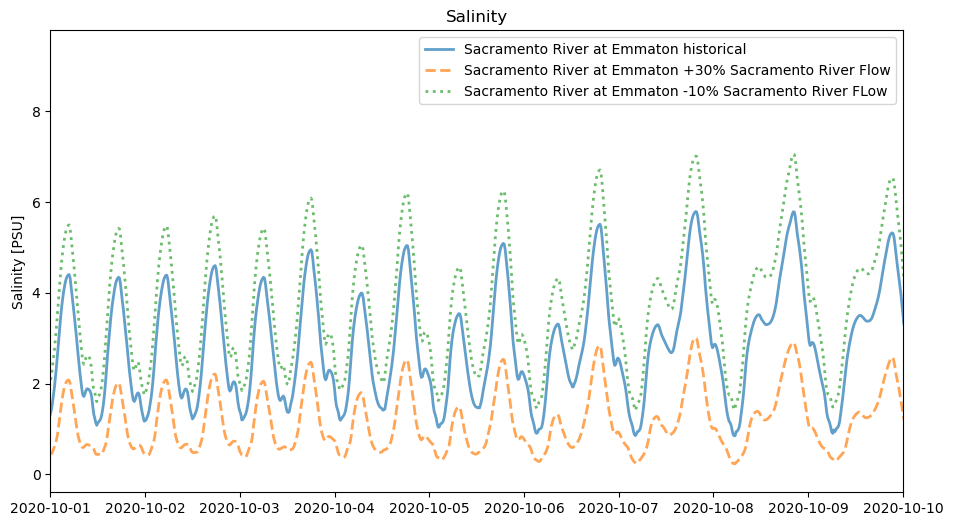

In [25]:
# Make a plot
plt.ioff()

#station_indices=[0, 208, 2, 62, 105]
#station_indices=[47,48,56,7,8,9] #first are 2 martinez, then Old River near Clifton court intake, last 3 are emmaton
station_indices=[9]#47,48,56,7,8,9,]
fig = plt.figure(figsize=(11,6))
ax = plt.gca()
# ax.grid(alpha=0.5)
for idx in station_indices:
    if idx==9:
        ls='--'
    else:
        ls='-'
    values15 = s15[str(idx)]
    ax.plot(s15.time, values15, label = stations[idx]+ " historical", linewidth=2, alpha =0.7)
    values16 = s16[str(idx)]
    ax.plot(s16.time, values16, label = stations[idx]+ " +30% Sacramento River Flow", linewidth=2, linestyle='--',alpha=0.7)
    values17 = s17[str(idx)]
    ax.plot(s17.time, values17, label = stations[idx]+ " -10% Sacramento River FLow", linewidth=2, linestyle=':',alpha=0.7)
    

leg = ax.legend()
print(ax)
ax.set_ylabel('Salinity [PSU]')
#ax.set_xlim(s13.time.iloc[0], s13.time.iloc[-1])
ax.set_xlim(pd.to_datetime("2020-10-01"),pd.to_datetime("2020-10-10"))
# ax.grid(which='major', color='b', linestyle='-')
ax.set_title("Salinity")
plt.show()
# ax.grid()



# Now plot the tidally filtered signal

In [19]:
#read in the data, drop the NaN rows and set the dates as the index

#df = pd.read_csv(infile, parse_dates=['datetime'], date_parser=dateparse)
s15_filt=pd.read_csv(file15_filt,parse_dates=['time'], date_format={'time': '%Y-%m-%d %H:%M:%S'}).dropna(axis='rows')
s15_filt.set_index("time",inplace=True)
s16_filt=pd.read_csv(file16_filt,parse_dates=['time'], date_format={'time': '%Y-%m-%d %H:%M:%S'}).dropna(axis='rows')
s16_filt.set_index("time",inplace=True)
s17_filt=pd.read_csv(file17_filt,parse_dates=['time'], date_format={'time': '%Y-%m-%d %H:%M:%S'}).dropna(axis='rows')
s17_filt.set_index("time",inplace=True)
s15_filt

,0,1,2,3,4,5,6,7,8,9,...,395,396,397,398,399,400,401,402,403,404
time,,,,,,,,,,,,,,,,,,,,,
2020-08-15 04:15:00,4.418100,0.072118,0.079966,-9999.0,0.170205,0.190286,0.206109,0.321834,2.629786,3.033444,...,0.162425,-999.0,-999.0,3.155772,-999.0,0.075832,0.610674,0.219573,0.171736,0.188083
2020-08-15 04:30:00,4.420073,0.072104,0.079966,-9999.0,0.170261,0.190385,0.206196,0.321831,2.632324,3.036366,...,0.162428,-999.0,-999.0,3.154856,-999.0,0.075832,0.610753,0.219672,0.171740,0.188074
2020-08-15 04:45:00,4.422031,0.072090,0.079967,-9999.0,0.170315,0.190484,0.206282,0.321828,2.634854,3.039273,...,0.162431,-999.0,-999.0,3.153953,-999.0,0.075832,0.610834,0.219769,0.171743,0.188065
2020-08-15 05:00:00,4.423976,0.072077,0.079967,-9999.0,0.170368,0.190582,0.206368,0.321825,2.637378,3.042164,...,0.162435,-999.0,-999.0,3.153064,-999.0,0.075831,0.610914,0.219866,0.171746,0.188056
2020-08-15 05:15:00,4.425909,0.072063,0.079967,-9999.0,0.170420,0.190680,0.206452,0.321821,2.639897,3.045041,...,0.162438,-999.0,-999.0,3.152189,-999.0,0.075831,0.610996,0.219961,0.171749,0.188049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28 18:00:00,0.379150,0.068244,0.216264,-9999.0,0.412444,0.336185,0.450905,0.262717,0.102747,0.103159,...,0.567183,-999.0,-999.0,0.335854,-999.0,0.117140,0.784563,0.699281,0.472982,0.323348
2021-12-28 18:15:00,0.378813,0.068277,0.216357,-9999.0,0.412617,0.336559,0.450928,0.262330,0.102644,0.103052,...,0.567142,-999.0,-999.0,0.335267,-999.0,0.117137,0.784098,0.699293,0.473056,0.323300
2021-12-28 18:30:00,0.378477,0.068308,0.216451,-9999.0,0.412791,0.336939,0.450949,0.261940,0.102542,0.102946,...,0.567100,-999.0,-999.0,0.334678,-999.0,0.117134,0.783631,0.699304,0.473128,0.323251


Axes(0.125,0.11;0.775x0.77)


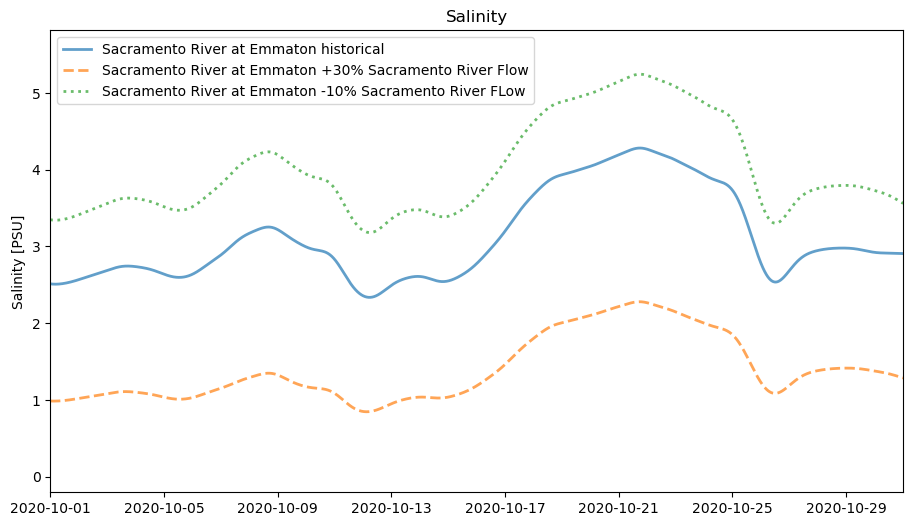

In [27]:
# Make a plot
plt.ioff()

#station_indices=[0, 208, 2, 62, 105]
#station_indices=[47,48,56,7,8,9] #first are 2 martinez, then Old River near Clifton court intake, last 3 are emmaton
station_indices=[9]#47,48,56,7,8,9,]
fig = plt.figure(figsize=(11,6))
ax = plt.gca()
# ax.grid(alpha=0.5)
for idx in station_indices:
    if idx==9:
        ls='--'
    else:
        ls='-'
    values15_filt = s15_filt[str(idx)]
    ax.plot(values15_filt, label = stations[idx]+ " historical", linewidth=2, alpha =0.7)
    values16_filt = s16_filt[str(idx)]
    ax.plot(values16_filt, label = stations[idx]+ " +30% Sacramento River Flow", linewidth=2, linestyle='--',alpha=0.7)
    values17_filt = s17_filt[str(idx)]
    ax.plot(values17_filt, label = stations[idx]+ " -10% Sacramento River FLow", linewidth=2, linestyle=':',alpha=0.7)
    

leg = ax.legend()
print(ax)
ax.set_ylabel('Salinity [PSU]')
#ax.set_xlim(s13.time.iloc[0], s13.time.iloc[-1])
ax.set_xlim(pd.to_datetime("2020-10-01"),pd.to_datetime("2020-10-31"))
# ax.grid(which='major', color='b', linestyle='-')
ax.set_title("Salinity")
plt.show()
# ax.grid()

